<a href="https://colab.research.google.com/github/Lewislou/Pytorch-pratical-Learning/blob/master/5_2_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part 1: Training and evaluating simple CNNs

__Before starting, we recommend you enable GPU acceleration if you're running on Colab.__

In [1]:
# Execute this code block to install dependencies when running on colab
try:
    import torch
except:
    from os.path import exists
    from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
    platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
    cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
    accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

    !pip install -q http://download.pytorch.org/whl/{accelerator}/torch-1.0.0-{platform}-linux_x86_64.whl torchvision

try: 
    import torchbearer
except:
    !pip install torchbearer

     |████████████████████████████████| 143kB 6.6MB/s 


## Simple Convolutional Neural Network for MNIST

Now that we have seen how to load the MNIST dataset and train a simple multi-layer perceptron model on it, we can now start to develop a more sophisticated convolutional neural network or CNN model. PyTorch provides a lot of capability for creating CNNs, and includes a large number of layer types and activation functions. In this part of the lab we will create a simple CNN for MNIST that demonstrates how to use all of the aspects of a modern CNN implementation, including Convolutional layers, Pooling layers and Dropout layers.

The first step is to import the classes and functions needed.

In [16]:
# automatically reload external modules if they change
%load_ext autoreload
%autoreload 2

import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchbearer
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchbearer import Trial

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Again, initialise the random number generator to a constant seed value for reproducibility of results.

In [0]:
# fix random seed for reproducibility
seed = 7
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True

Next we need to load the MNIST dataset. Unlike with the MLP example we looked at previously, we don't want to flatten the images into vectors, although we do still want to convert the PIL images to tensors.

In PyTorch, images are represented as tensors with dimensions `[pixels][height][width]`. In the case of RGB, the first dimension, pixels, would be 3 for the red, green and blue components. In the case of MNIST where the pixel values are greyscale, the pixel dimension is set to 1.

In [0]:
# convert each image to tensor format
transform = transforms.Compose([
    transforms.ToTensor()  # convert to tensor
])

# load data
trainset = MNIST(".", train=True, download=True, transform=transform)
testset = MNIST(".", train=False, download=True, transform=transform)

# create data loaders
trainloader = DataLoader(trainset, batch_size=128, shuffle=True)
testloader = DataLoader(testset, batch_size=128, shuffle=True)

Next we define our neural network model.

Convolutional neural networks are more complex than standard multi-layer perceptrons, so we will start by using a simple structure to begin with that uses all of the elements required for near state of the art results. The network architecture is summarised below:

1. The first hidden layer is a convolutional layer called a `Convolution2D`. The layer has 32 feature maps, which with the size of 5×5 and a rectified linear unit activation function.
2. Next we define a pooling layer that takes the max called `MaxPooling2D`. It is configured with a pool size of 2×2.
3. The next layer is a regularization layer using dropout called `Dropout`. It is configured to randomly exclude 20% of neurons in the layer in order to reduce overfitting.
4. Next is an operation that flattens or reshapes the tensor to a vector. It allows the output to be processed by standard fully connected layers.
5. Next a fully connected layer with 128 neurons and rectifier linear unit activation function.
6. Finally, the output layer has 10 neurons for the 10 classes.

Just like with the MLP we create a PyTorch `nn.Module` subclass to define our network model:

In [0]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, (5, 5), padding=0)
        self.fc1 = nn.Linear(32 * 12**2, 128)
        self.fc2 = nn.Linear(128, 10)
            
    def forward(self, x):
        out = self.conv1(x)
        out = F.relu(out)
        out = F.max_pool2d(out, (2,2))
        out = F.dropout(out, 0.2)
        out = out.view(out.shape[0], -1)
        out = self.fc1(out)
        out = F.relu(out)
        out = self.fc2(out)
        return out

Note in the above code when we use the `view` method to _flatten_ the tensor we must preserve the batch dimension of the data; passing `-1` as the second argument tells view to compute the size of the dimension represented by the `-1` automatically. The input to the forward method has shape `[batch_size][pixels][height][width]` and we want the final output to be `[batch_size][num_classes=10]`. 

__Answer the following questions (enter the answer in the box below each one):__

__1.__ What is the shape of the tensor output by the `conv1` layer?

YOUR ANSWER HERE
（1,28,28）

__2.__ If the `conv1` layer had a kernel shape of `(7,3)` what would the output shape be?

YOUR ANSWER HERE
(1,26,30)

As before, the model is trained using cross-entropy loss and the ADAM gradient descent algorithm. The CNN is fit over 10 epochs with a batch size of 128. We use torchbearer to minimise the training and evaluation code we need to write:

In [0]:
# build the model
model = SimpleCNN()

# define the loss function and the optimiser
loss_function = nn.CrossEntropyLoss()
optimiser = optim.Adam(model.parameters())

device = "cuda:0" if torch.cuda.is_available() else "cpu"
trial = Trial(model, optimiser, loss_function, metrics=['loss', 'accuracy']).to(device)
trial.with_generators(trainloader, test_generator=testloader)
trial.run(epochs=10)
results = trial.evaluate(data_key=torchbearer.TEST_DATA)
print(results)


{'test_loss': 0.03689071163535118, 'test_acc': 0.988599956035614}


You should see that the network achieves an accuracy of 98.91% which is better than the simple multi-layer perceptron model we tried previously.

## An improved CNN

Now that we have seen how to create a simple CNN, let’s take a look at a model capable of close to state of the art results. This time you will implement a large CNN architecture with additional convolutional, max pooling layers and fully connected layers. The network topology of the model is summarised as follows:

1. Convolutional layer with 30 feature maps of size 5×5 and ReLU activation.
2. Pooling layer taking the max over 2×2 patches.
3. Convolutional layer with 15 feature maps of size 3×3 and ReLU activation.
4. Pooling layer taking the max over 2×2 patches.
5. Dropout layer with a probability of 20%.
6. Flatten layer.
7. Fully connected layer with 128 neurons and ReLU activation.
8. Fully connected layer with 50 neurons and ReLU activation.
9. Linear output layer.

__Complete the implementation of the BetterCNN module which implements the above network in the following code block.__

In [0]:
import torch 
import torch.nn.functional as F
from torch import nn

# Model Definition
class BetterCNN(nn.Module):
    def __init__(self):
        super(BetterCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 30, (5, 5), padding=0)
        self.conv2 = nn.Conv2d(30, 15, (3, 3), padding=0)
        self.fc1 = nn.Linear(15 * 5**2, 128)
        self.fc2 = nn.Linear(128, 50)
        self.fc3 = nn.Linear(50, 10)
    
    def forward(self, x):
        out = self.conv1(x)
        out = F.relu(out)
        out = F.max_pool2d(out, (2,2))
        out = self.conv2(out)
        out = F.relu(out)
        out = F.max_pool2d(out,(2,2))
        out = F.dropout(out, 0.2)
        out = out.view(out.shape[0], -1)
        out = self.fc1(out)
        out = F.relu(out)
        out = self.fc2(out)
        out = F.relu(out)
        out = self.fc3(out)
        return out

Once you've completed the implementation, save the file and run the following code block to train and evaluate the model.

In [20]:
#reset the data loaders
torch.manual_seed(seed)
trainloader = DataLoader(trainset, batch_size=128, shuffle=True)
testloader = DataLoader(testset, batch_size=128, shuffle=True)

# build the model
model = BetterCNN()

# define the loss function and the optimiser
loss_function = nn.CrossEntropyLoss()
optimiser = optim.Adam(model.parameters())

device = "cuda:0" if torch.cuda.is_available() else "cpu"
trial = Trial(model, optimiser, loss_function, metrics=['loss', 'accuracy']).to(device)
trial.with_generators(trainloader, test_generator=testloader)
trial.run(epochs=10)
results = trial.evaluate(data_key=torchbearer.TEST_DATA)
print(results)

#assert results['test_acc'] > 0.99



{'test_loss': 0.04028724879026413, 'test_acc': 0.986799955368042}


If correctly implemented you should see this slightly larger model achieves the respectable classification accuracy of 99.13%.

## Saving models

Being able to train a model is fine, but in practice once we've trained the model we probably want to save the result so we can reuse it at a later time. PyTorch makes saving the model easy using the `torch.save(state, filepath)` function. This will save the weights of the model so they can be loaded into a new instance at a later point. 

__Run the following code to save the weights for use in the next part of the lab.__

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
#save the trained model weights
torch.save(model.state_dict(), "./bettercnn.weights")

__If you are running on Colab, run the following to download the weights to the local machine:__

In [0]:
##from google.colab import files
#files.download('bettercnn.weights')

In [9]:
# Execute this code block to install dependencies when running on colab
try:
    import torch
except:
    from os.path import exists
    from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
    platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
    cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
    accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

    !pip install -q http://download.pytorch.org/whl/{accelerator}/torch-1.0.0-{platform}-linux_x86_64.whl torchvision
    
try: 
    import torchbearer
except:
    !pip install torchbearer

try:
    from google.colab import files
    uploaded = files.upload()
except:
    print("Not running on colab. Ignoring.")

!wget http://comp6248.ecs.soton.ac.uk/labs/lab5/0.PNG
!wget http://comp6248.ecs.soton.ac.uk/labs/lab5/1.PNG
!wget http://comp6248.ecs.soton.ac.uk/labs/lab5/2.PNG
!wget http://comp6248.ecs.soton.ac.uk/labs/lab5/3.PNG
!wget http://comp6248.ecs.soton.ac.uk/labs/lab5/4.PNG
!wget http://comp6248.ecs.soton.ac.uk/labs/lab5/5.PNG
!wget http://comp6248.ecs.soton.ac.uk/labs/lab5/6.PNG
!wget http://comp6248.ecs.soton.ac.uk/labs/lab5/7.PNG
!wget http://comp6248.ecs.soton.ac.uk/labs/lab5/8.PNG
!wget http://comp6248.ecs.soton.ac.uk/labs/lab5/9.PNG

--2020-05-01 10:25:59--  http://comp6248.ecs.soton.ac.uk/labs/lab5/0.PNG
Resolving comp6248.ecs.soton.ac.uk (comp6248.ecs.soton.ac.uk)... 185.199.109.153, 185.199.108.153, 185.199.110.153, ...
Connecting to comp6248.ecs.soton.ac.uk (comp6248.ecs.soton.ac.uk)|185.199.109.153|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2514 (2.5K) [image/png]
Saving to: ‘0.PNG’

0.PNG               100%[===================>]   2.46K  --.-KB/s    in 0s      

2020-05-01 10:26:00 (365 MB/s) - ‘0.PNG’ saved [2514/2514]

--2020-05-01 10:26:03--  http://comp6248.ecs.soton.ac.uk/labs/lab5/1.PNG
Resolving comp6248.ecs.soton.ac.uk (comp6248.ecs.soton.ac.uk)... 185.199.109.153, 185.199.108.153, 185.199.110.153, ...
Connecting to comp6248.ecs.soton.ac.uk (comp6248.ecs.soton.ac.uk)|185.199.109.153|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2448 (2.4K) [image/png]
Saving to: ‘1.PNG’

1.PNG               100%[===================>]   2.39K  --.-KB/s    in 0s  

In [24]:
%matplotlib inline
# automatically reload external modules if they change
%load_ext autoreload
%autoreload 2

import torch 
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch import nn

import torch 
import torch.nn.functional as F
from torch import nn

# Model Definition
class BetterCNN(nn.Module):
    
    def __init__(self):
        super(BetterCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 30, (5, 5), padding=0)
        self.conv2 = nn.Conv2d(30, 15, (3, 3), padding=0)
        self.fc1 = nn.Linear(15 * 5**2, 128)
        self.fc2 = nn.Linear(128, 50)
        self.fc3 = nn.Linear(50, 10)
    
    def forward(self, x):
        out = self.conv1(x)
        out = F.relu(out)
        out = F.max_pool2d(out, (2,2))
        out = self.conv2(out)
        out = F.relu(out)
        out = F.max_pool2d(out,(2,2))
        out = F.dropout(out, 0.2)
        out = out.view(out.shape[0], -1)
        out = self.fc1(out)
        out = F.relu(out)
        out = self.fc2(out)
        out = F.relu(out)
        out = self.fc3(out)
        return out

# build the model and load state
model = BetterCNN()
model.load_state_dict(torch.load('./bettercnn.weights'))

# put model in eval mode
model = model.eval() 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


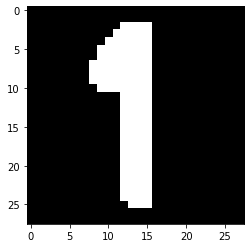

In [25]:
from PIL import Image
import torchvision

transform = torchvision.transforms.ToTensor()
im = transform(Image.open("1.PNG"))

plt.imshow(im[0], cmap=plt.get_cmap('gray'))

In [26]:
batch = im.unsqueeze(0)
predictions = model(batch)

print("logits:", predictions.data)

_, predicted_class = predictions.max(1)

print("predicted class:", predicted_class.item())

logits: tensor([[-5.0783,  2.0296, -2.2536, -4.7284, -2.9327, -2.4547, -4.1717,  0.2422,
          4.9949,  0.5635]])
predicted class: 8


predicted class: 0
predicted class: 8
predicted class: 2
predicted class: 3
predicted class: 4
predicted class: 5
predicted class: 5
predicted class: 7
predicted class: 8
predicted class: 9


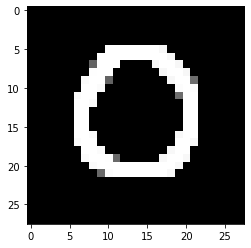

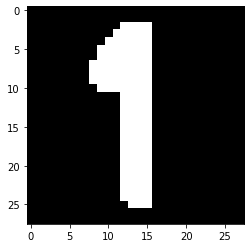

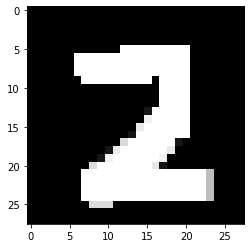

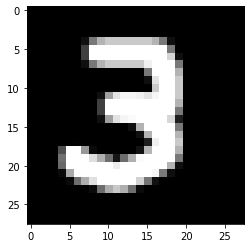

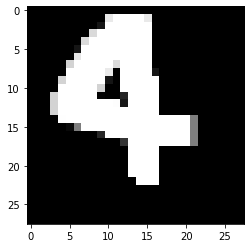

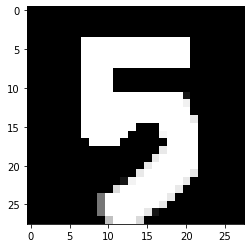

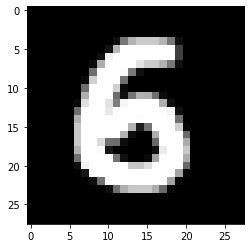

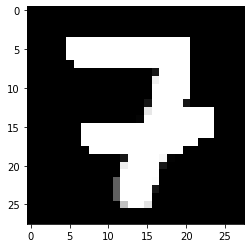

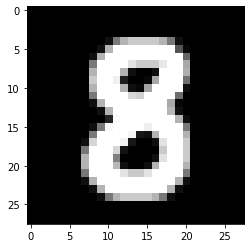

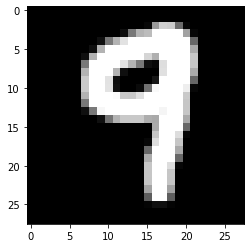

In [27]:
for i in range(10):
  name = str(i)+'.PNG'
  im = transform(Image.open(name))
  plt.figure()
  plt.imshow(im[0], cmap=plt.get_cmap('gray'))
  batch = im.unsqueeze(0)
  predictions = model(batch)
  _, predicted_class = predictions.max(1)
  print("predicted class:", predicted_class.item())